### Import the data set

In [1]:
import warnings
warnings.filterwarnings('ignore' )

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [2]:
df = pd.read_csv("H1_data.csv")
df.head()

,Time,Power
0,1/1/2020 0:00,191.225983
1,1/1/2020 1:00,290.682000
2,1/1/2020 2:00,217.358167
3,1/1/2020 3:00,166.289250
4,1/1/2020 4:00,143.285783


In [3]:
df["Time"] = pd.to_datetime(df["Time"])
df.set_index("Time", inplace=True)

In [4]:
df.head()

,Power
Time,
2020-01-01 00:00:00,191.225983
2020-01-01 01:00:00,290.682000
2020-01-01 02:00:00,217.358167
2020-01-01 03:00:00,166.289250
2020-01-01 04:00:00,143.285783


<AxesSubplot:xlabel='Time'>

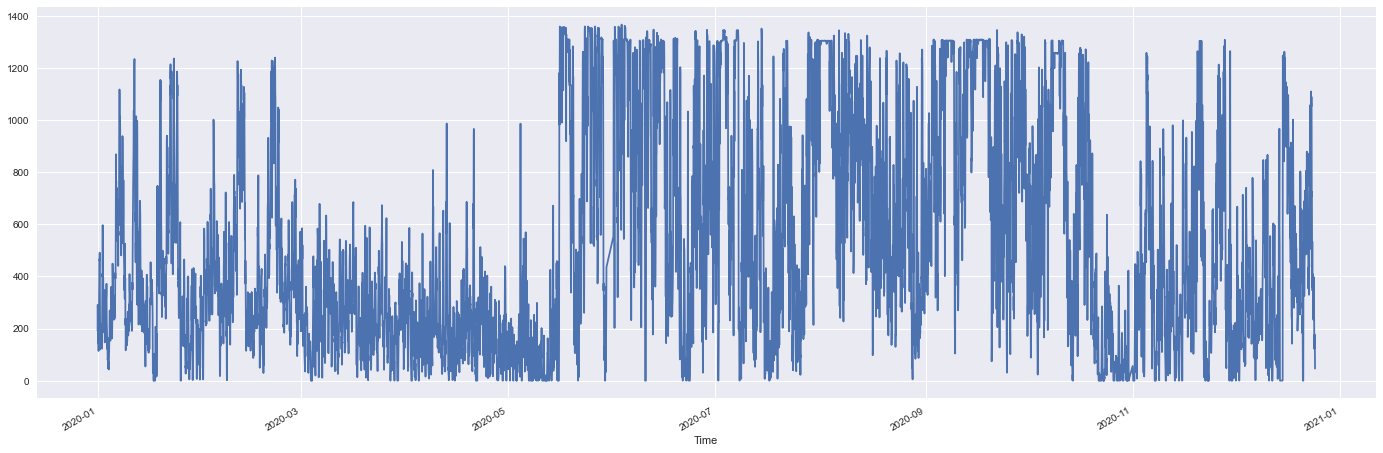

In [5]:
df['Power'].plot(figsize=(24,8))

### Testing for stationary_ADF Test

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
test_result=adfuller(df['Power'])

In [8]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Power):
    result=adfuller(Power)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [9]:
adfuller_test(df['Power'])

ADF Test Statistic : -6.923461476259721
p-value : 1.1308958384433104e-09
#Lags Used : 34
Number of Observations Used : 8504
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


So,no need to do differencing part.

### Figure out order of the ARIMA Model 

In [10]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df['Power'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=108773.229, Time=8.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=109308.109, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=109306.704, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=109305.470, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109306.110, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=108780.372, Time=5.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=108791.347, Time=5.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=108775.201, Time=14.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=108775.411, Time=14.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=108891.830, Time=5.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=108774.156, Time=12.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=108776.882, Time=9.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=108776.331, Time=17.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=108771.230, Time=4.72 sec
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8539
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -54380.615
Date:                Fri, 03 Feb 2023   AIC                         108771.230
Time:                        04:24:33   BIC                         108806.491
Sample:                             0   HQIC                        108783.260
                               - 8539                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5075      0.055      9.176      0.000       0.399       0.616
ar.L2          0.2244      0.048      4.643      0.000       0.130       0.319
ma.L1         -0.5356      0.054     -9.923      0.000      -0.641      -0.430
ma.L2         -0.3937      0.052     -7.552      0.000      -0.496      -0.292
sigma2      1.994e+04    178.982    111.415      0.000    1.96e+04    2.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6915.01
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Start to fit the model 

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore' )

#### Split data into Training and Testing

In [12]:
print(df.shape)
train=df.iloc[:300]
test=df.iloc[300:]
print(train.shape,test.shape)

(8539, 1)
(300, 1) (8239, 1)


#### Train the model

In [13]:
model=ARIMA(train['Power'],order=(2,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Power   No. Observations:                  300
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1771.296
Date:                Fri, 03 Feb 2023   AIC                           3550.591
Time:                        04:24:33   BIC                           3565.393
Sample:                    01-01-2020   HQIC                          3556.516
                         - 01-13-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0089      0.071     14.163      0.000       0.869       1.149
ar.L2         -0.1922      0.045     -4.303      0.000      -0.280      -0.105
ma.L1         -0.9055      0.053    -17.085      0.000      -1.009      -0.802
sigma2      8180.3642    470.174     17.399      0.000    7258.839    9101.889
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               179.09
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.48   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot residual errors 

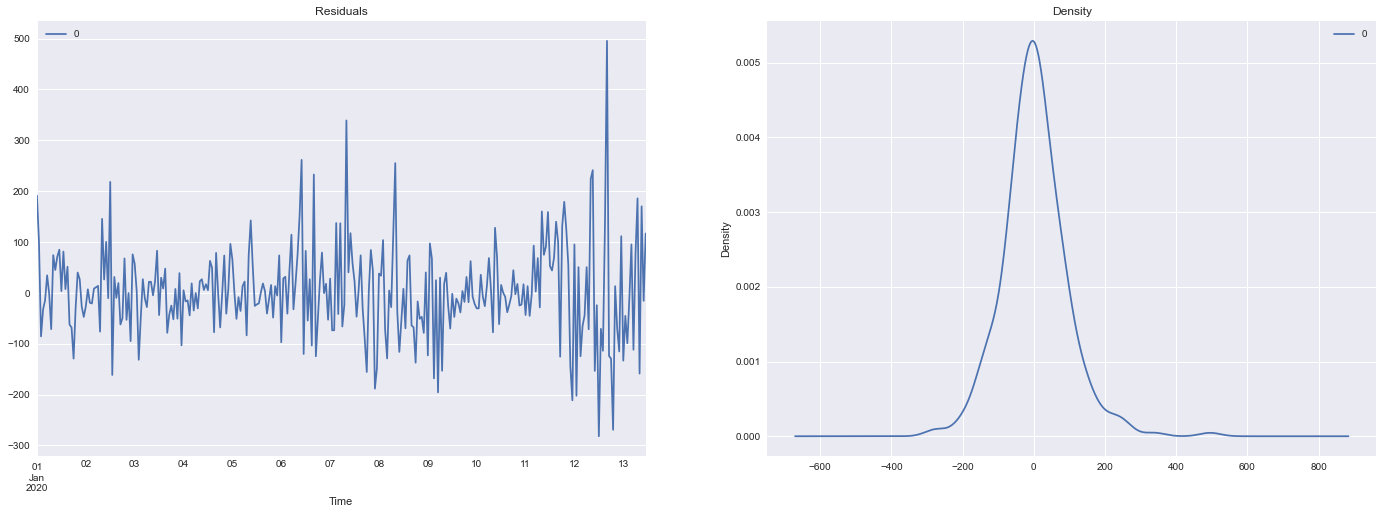

In [14]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],figsize=(24,8))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

### Make prediction on Test Set 

In [15]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,dynamic=False,typ='level')

pred.index=df.index[start:end+1]
print(pred)

Time
2020-01-13 12:00:00    688.696671
2020-01-13 13:00:00    667.200883
2020-01-13 14:00:00    645.833954
2020-01-13 15:00:00    628.408649
2020-01-13 16:00:00    614.935299
                          ...    
2020-12-24 14:00:00    573.181642
2020-12-24 15:00:00    573.181642
2020-12-24 16:00:00    573.181642
2020-12-24 17:00:00    573.181642
2020-12-24 18:00:00    573.181642
Name: predicted_mean, Length: 8239, dtype: float64


<AxesSubplot:title={'center':'Actuals vs Predicted'}, xlabel='Time'>

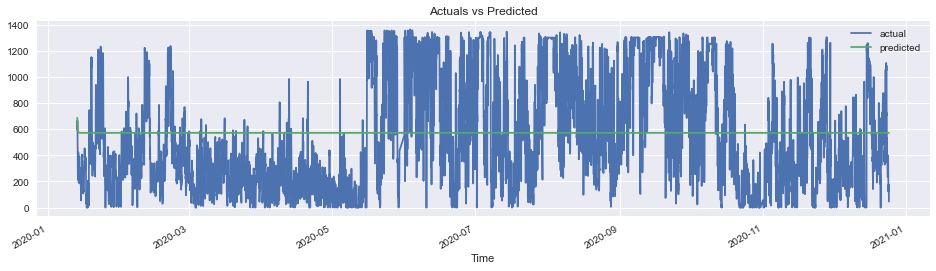

In [16]:
# Actual vs Fitted Plot
actual = test.Power
pd.DataFrame({"actual": actual, "predicted": pred}).plot(
    title="Actuals vs Predicted", figsize=(16, 4)
)

In [17]:
pred.to_csv('sample.csv', sep=';')

In [18]:
test['Power'].mean()

528.6763774722463

In ARIMA,
Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

In [23]:
from sklearn.metrics import accuracy_score,r2_score,mean_absolute_error, mean_squared_error
import sklearn.metrics as metrics
from math import sqrt

rmse=sqrt(mean_squared_error(pred,test['Power']))
print('RMSE :',rmse)

mse = metrics.mean_squared_error(pred,test['Power'])
print('MSE :',mse)

mae = metrics.mean_absolute_error(pred,test['Power'])
print('MAE :',mae)

corr = np.corrcoef(pred,test['Power'])[0,1]   # corr
print('corr :',corr)

RMSE : 420.15435916824225
MSE : 176529.6855280763
MAE : 366.18397173328043
corr : -0.0017963826021146678


### Retrain the model on entire data set

In [20]:
model2=ARIMA(df['Power'],order=(2,1,1))
model2=model2.fit()
df.tail()

,Power
Time,
2020-12-24 14:00:00,174.598783
2020-12-24 15:00:00,169.276317
2020-12-24 16:00:00,176.343850
2020-12-24 17:00:00,85.532250
2020-12-24 18:00:00,46.165267


### For future dates 

In [21]:
pred2=model2.predict(starts=len(df),end=len(df)+30,typ='levels').rename('ARIMA Prediction')
print(pred2)

0         0.000000
1       191.305408
2       292.278192
3       205.594156
4       163.632349
           ...    
8565    323.592755
8566    323.628786
8567    323.655941
8568    323.676407
8569    323.691832
Name: ARIMA Prediction, Length: 8570, dtype: float64
